# Random Forest

## Task Description

In this exercise, your task is to classify table data using a Decision Tree and a Random Forest classifiers.

You have two datasets: `iris_2D.csv` and `adult_onehotencoded.csv`.

`iris_2D.csv` contains three different types of irises' and their petal and sepal sizes.

`adult_onehotencoded.csv` contains two groups of income: <=50K and >50K and other features such as education, gender, occupation, etc.

You have to implement the following:

1. Decision Tree classifier using sklearn with the arguments (see function's signature) and random_state=42;

1. Pipeline that splits data into 80\% of training and 20\% of test data with shuffling and random_state=42, trains a Decision Tree classifier, and predicts the labels for the test data;

1. Same as 1 & 2 but for a Random Forest classifier;

4. Top-N features of a classifier by their importance.

Note: always set your random_state to make your results reproducible. However, do not fix it in production as it prevents your model from being exposed to the natural randomness of new data, potentially leading to overconfident or less reliable predictions.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy.typing import ArrayLike
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from typing import Optional

sns.set_style("whitegrid")

In [2]:
def load_table_dataset(
    dataset_path: str,
) -> tuple[ArrayLike, ArrayLike, list[str]]:
    """Load a dataset from a CSV file using pandas.
    The last column is treated as the target variable, and all other columns are treated as features.
    Args:
        dataset_path (str): Path to the CSV file.
    Returns:
        tuple: A tuple containing:
            - X (ArrayLike): Feature matrix.
            - y (ArrayLike): Target vector.
            - feature_names (list[str]): List of feature names.
    """

    df = pd.read_csv(dataset_path)
    if "fnlwgt" in df.columns:
        df.drop(columns=["fnlwgt"], inplace=True)

    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()

    feature_names = df.iloc[:, :-1].columns.tolist()

    return X, y, feature_names

In [3]:
def stratified_kfold(
    classifier: ClassifierMixin, X: ArrayLike, y: ArrayLike, k: int = 10
) -> tuple[float, float]:
    """Perform k-fold cross-validation on the given classifier and dataset.
    Args:
        classifier: The classifier to evaluate.
        X (ArrayLike): Feature matrix.
        y (ArrayLike): Target vector.
        k (int): Number of folds for cross-validation.
    Returns:
        tuple: A tuple containing:
            - mean_train_score (float): Mean training score across all folds.
            - mean_val_score (float): Mean validation score across all folds.
    """
    stratified_shuffled_kfold = StratifiedShuffleSplit(
        n_splits=k, test_size=1.0 / k, random_state=42
    )

    val_scores = np.empty((k,))
    train_scores = np.empty((k,))

    for i, (train_index, val_index) in enumerate(stratified_shuffled_kfold.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        classifier.fit(X_train, y_train)

        y_val_pred = classifier.predict(X_val)
        y_train_pred = classifier.predict(X_train)

        val_scores[i] = accuracy_score(y_val, y_val_pred)
        train_scores[i] = accuracy_score(y_train, y_train_pred)

    mean_val_score = np.mean(val_scores)
    mean_train_score = np.mean(train_scores)

    return mean_train_score, mean_val_score

In [4]:
def get_score_curve_data(
    X: ArrayLike,
    y: ArrayLike,
    classifier: ClassifierMixin,
    hyperparam_name: str,
    hyperparam_values: any,
) -> tuple[int, ArrayLike, ArrayLike]:
    """Test and plot the performance of a classifier with different hyperparameter values.
    Args:
        X (ArrayLike): Feature matrix.
        y (ArrayLike): Target vector.
        classifier: The classifier to evaluate.
        hyperparam_name (str): Name of the hyperparameter to test.
        hyperparam_values (any): Values of the hyperparameter to test.
    Returns:
        tuple: A tuple containing:
            - best_hyperparam_value (int): The best hyperparameter value.
            - train_scores (ArrayLike): Training scores for each hyperparameter value.
            - val_scores (ArrayLike): Validation scores for each hyperparameter value.
    """

    train_scores = []
    val_scores = []
    for val in hyperparam_values:
        print(f"Testing {hyperparam_name} = {val}")
        classifier.set_params(**{hyperparam_name: val})
        train_score, val_score = stratified_kfold(classifier=classifier, X=X, y=y, k=5)
        train_scores.append(train_score)
        val_scores.append(val_score)

    return np.argmax(val_scores).item(), train_scores, val_scores

In [5]:
def plot_score_curve(
    hyperparam_name: str,
    hyperparam_values: ArrayLike,
    train_scores: ArrayLike,
    val_scores: Optional[ArrayLike] = None,
    score_name: str = "Accuracy",
) -> None:
    """Plots the score curve.
    Args:
        hyperparam_name (str): Name of the hyperparameter.
        hyperparam_values (ArrayLike): Values of the hyperparameter.
        train_scores (ArrayLike): Training scores for each hyperparameter value.
        val_scores (Optional[ArrayLike]): Validation scores for each hyperparameter value.
        score_name (str): Name of the score metric. Default is "Accuracy".
    """

    plt.plot(
        hyperparam_values,
        train_scores,
        color="#D81B60",
        linewidth=2.5,
        label=f"Train {score_name}",
    )
    if val_scores is not None:
        plt.plot(
            hyperparam_values,
            val_scores,
            color="#1E88E5",
            linewidth=2.5,
            label=f"Valid {score_name}",
        )
    plt.legend()
    plt.xlabel(hyperparam_name)
    plt.ylabel(f"{score_name}")
    plt.grid(True)
    plt.show()

## Iris dataset

### Decision Tree Classifier

In [20]:
def decision_tree_classifier(
    X: ArrayLike,
    y: ArrayLike,
    max_depth: int | None = None,
    min_samples_split: int = 2,
    min_samples_leaf: int = 1,
) -> DecisionTreeClassifier:
    """Create and train a decision tree classifier.
    Args:
        X (ArrayLike): Feature matrix.
        y (ArrayLike): Target vector.
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split an internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
    Returns:
        DecisionTreeClassifier: Trained decision tree classifier.
    """

    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    clf.fit(X, y)
    return clf

In [24]:
def pipeline_decision_tree_classifier(
    X: ArrayLike,
    y: ArrayLike,
    max_depth: int | None = None,
    min_samples_split: int = 2,
    min_samples_leaf: int = 1,
) -> DecisionTreeClassifier:
    """Create a pipeline for table data classification using a decision tree classifier.
    Args:
        X (ArrayLike): Feature matrix.
        y (ArrayLike): Target vector.
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split an internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
    Returns:
        DecisionTreeClassifier: Trained decision tree classifier.
    """

    clf = decision_tree_classifier(
        X=X,
        y=y,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Accuracy score: {accuracy_score(y_test, y_pred):.3f}")

    return clf

In [37]:
X, y, feature_names = load_table_dataset("iris_2D.csv")

clf = pipeline_decision_tree_classifier(
    X, y, max_depth=9, min_samples_split=20, min_samples_leaf=1
)

Accuracy score: 0.733


[Text(0.35714285714285715, 0.9285714285714286, 'sepal length (cm) <= 5.45\ngini = 0.667\nsamples = 120\nvalue = [40, 40, 40]'),
 Text(0.14285714285714285, 0.7857142857142857, 'sepal width (cm) <= 2.8\ngini = 0.18\nsamples = 41\nvalue = [37, 3, 1]'),
 Text(0.25, 0.8571428571428572, 'True  '),
 Text(0.07142857142857142, 0.6428571428571429, 'gini = 0.56\nsamples = 5\nvalue = [1, 3, 1]'),
 Text(0.21428571428571427, 0.6428571428571429, 'gini = 0.0\nsamples = 36\nvalue = [36, 0, 0]'),
 Text(0.5714285714285714, 0.7857142857142857, 'sepal length (cm) <= 6.15\ngini = 0.535\nsamples = 79\nvalue = [3, 37, 39]'),
 Text(0.4642857142857143, 0.8571428571428572, '  False'),
 Text(0.35714285714285715, 0.6428571428571429, 'sepal width (cm) <= 3.45\ngini = 0.434\nsamples = 36\nvalue = [3, 26, 7]'),
 Text(0.2857142857142857, 0.5, 'sepal length (cm) <= 5.55\ngini = 0.334\nsamples = 33\nvalue = [0, 26, 7]'),
 Text(0.21428571428571427, 0.35714285714285715, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]'),
 Text

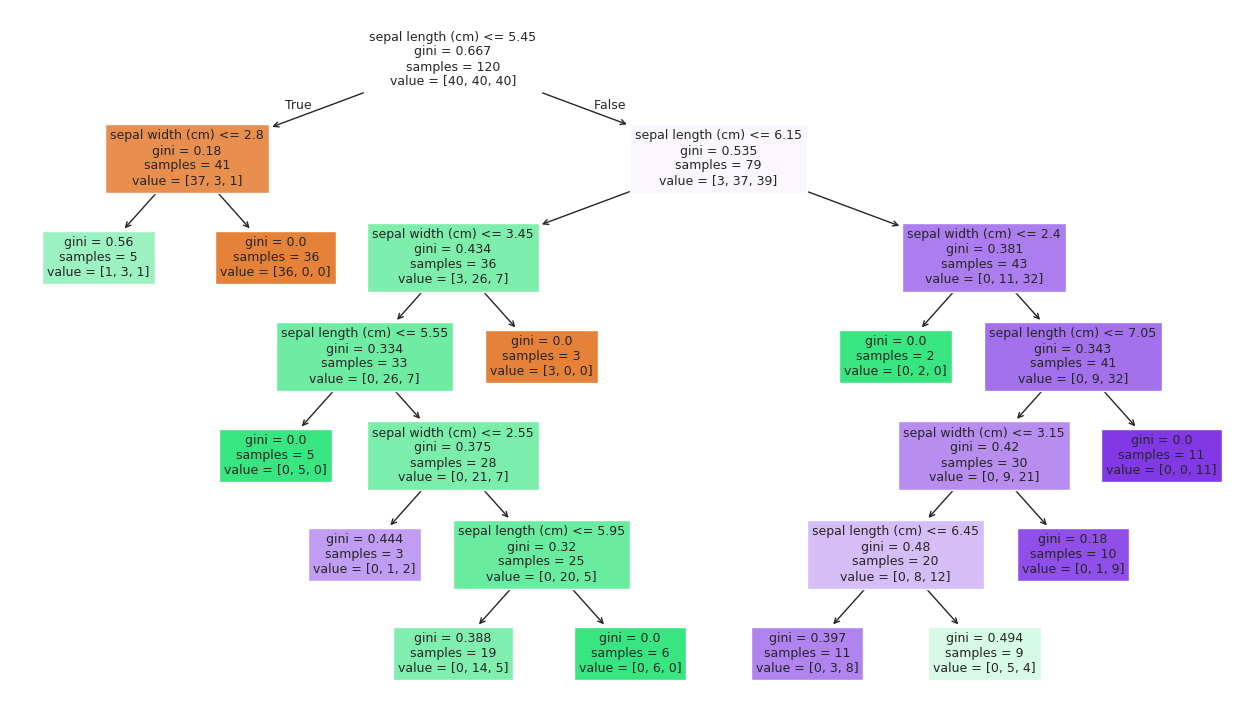

In [11]:
_, ax = plt.subplots(figsize=(16, 9))
plot_tree(clf, ax=ax, feature_names=feature_names, filled=True)


### Random Forest Classifier

In [14]:
def random_forest_classifier(
    X: ArrayLike,
    y: ArrayLike,
    n_estimators: int = 100,
    max_depth: int | None = None,
    min_samples_split: int = 2,
    min_samples_leaf: int = 1,
) -> RandomForestClassifier:
    """Create and train a decision tree classifier.
    Args:
        X (ArrayLike): Feature matrix.
        y (ArrayLike): Target vector.
        n_estimators (int): Number of trees in the forest.
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split an internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
    Returns:
        RandomForestClassifier: Trained random forest classifier.
    """

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    clf.fit(X, y)
    return clf

In [26]:
def pipeline_random_forest_classifier(
    X: ArrayLike,
    y: ArrayLike,
    n_estimators: int = 100,
    max_depth: int | None = None,
    min_samples_split: int = 2,
    min_samples_leaf: int = 1,
) -> RandomForestClassifier:
    """Create a pipeline for table data classification using a decision tree classifier.
    Args:
        X (ArrayLike): Feature matrix.
        y (ArrayLike): Target vector.
        max_depth (int): Maximum depth of the tree.
        min_samples_split (int): Minimum number of samples required to split an internal node.
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node.
    Returns:
        RandomForestClassifier: Trained random forest classifier.
    """
    clf = random_forest_classifier(
        X=X,
        y=y,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy score: {accuracy_score(y_test, y_pred):.3f}")

    return clf

In [ ]:
X, y, feature_names = load_table_dataset("iris_2D.csv")

clf = pipeline_random_forest_classifier(
    X,
    y,
    n_estimators=10,
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=1,
)

Accuracy score: 0.833


Testing n_estimators = 1
Testing n_estimators = 6
Testing n_estimators = 11
Testing n_estimators = 16
Testing n_estimators = 21
Testing n_estimators = 26
Testing n_estimators = 31
Testing n_estimators = 36
Testing n_estimators = 41
Testing n_estimators = 46
Testing n_estimators = 51
Testing n_estimators = 56
Testing n_estimators = 61
Testing n_estimators = 66
Testing n_estimators = 71
Testing n_estimators = 76
Testing n_estimators = 81
Testing n_estimators = 86
Testing n_estimators = 91
Testing n_estimators = 96


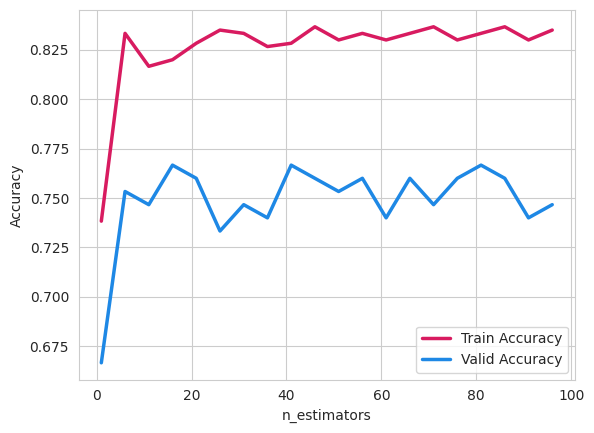

In [ ]:
# find out the best n_estimators hyperparameter
best_n_estimators, train_scores, val_scores = get_score_curve_data(
    X=X,
    y=y,
    classifier=RandomForestClassifier(max_depth=None, min_samples_split=20, min_samples_leaf=1),
    hyperparam_name="n_estimators",
    hyperparam_values=np.arange(1, 100, 5),
)
plot_score_curve(
    hyperparam_name="n_estimators",
    hyperparam_values=np.arange(1, 100, 5),
    train_scores=train_scores,
    val_scores=val_scores,
    score_name="Accuracy",
)

In [41]:
print(f"Best n_estimators: {best_n_estimators + 1}")  # +1 because np.argmax returns index

Best n_estimators: 9


## Adult dataset

### Decision Tree Classifier

In [42]:
X, y, feature_names = load_table_dataset("adult_onehotencoded.csv")

clf = pipeline_decision_tree_classifier(
    X, y, max_depth=5, min_samples_split=2, min_samples_leaf=1
)

Accuracy score: 0.853


Testing max_depth = 1
Testing max_depth = 2
Testing max_depth = 3
Testing max_depth = 4
Testing max_depth = 5
Testing max_depth = 6
Testing max_depth = 7
Testing max_depth = 8
Testing max_depth = 9
Testing max_depth = 10
Hyperparameter name: max_depth
Best hyperparameter value: 9


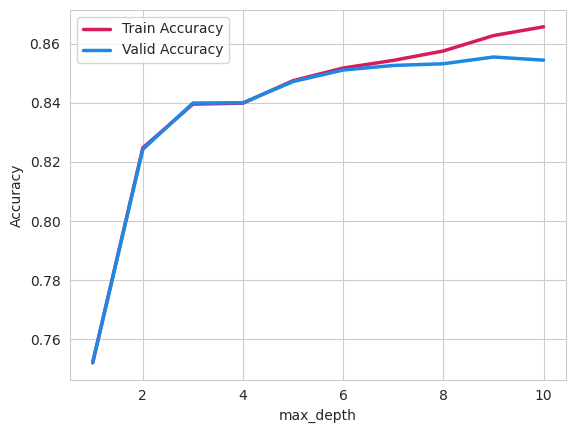

In [43]:
hyperparam_name = "max_depth"
hyperparam_values = np.arange(1, 11)

best_hyperparam_value, train_scores, val_scores = get_score_curve_data(
    X, y, clf, hyperparam_name, hyperparam_values
)

print(f"Hyperparameter name: {hyperparam_name}")
print(f"Best hyperparameter value: {hyperparam_values[best_hyperparam_value]}")

plot_score_curve(
    hyperparam_name,
    hyperparam_values,
    train_scores,
    val_scores,
)

#### Questions:

1. What is the best `max_depth` for the Decision Tree Classifier on this dataset? (All other parameters stay fixed)
2. What other parameters can you tweak for the Decision Tree Classifier except `max_depth`?
3. What is the best set of parameters for the Decision Tree Classifier for this dataset?
    - Note: you could use grid search to figure it out.

### Random Forest Classifier

In [44]:
X, y, feature_names = load_table_dataset("adult_onehotencoded.csv")

clf = pipeline_random_forest_classifier(
    X,
    y,
    n_estimators=10,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
)

Accuracy score: 0.840


In [45]:
hyperparam_name = "n_estimators"
hyperparam_values = np.arange(1, 11)

best_hyperparam_value, train_scores, val_scores = get_score_curve_data(
    X, y, clf, hyperparam_name, hyperparam_values
)

print(f"Hyperparameter name: {hyperparam_name}")
print(f"Best hyperparameter value: {hyperparam_values[best_hyperparam_value]}")

plot_score_curve(
    hyperparam_name,
    hyperparam_values,
    train_scores,
    val_scores,
)

Testing n_estimators = 1
Testing n_estimators = 2
Testing n_estimators = 3
Testing n_estimators = 4
Testing n_estimators = 5
Testing n_estimators = 6
Testing n_estimators = 7
Testing n_estimators = 8
Testing n_estimators = 9
Testing n_estimators = 10


KeyboardInterrupt: 

#### Questions:

1. What is the best `n_estimators` for the Random Forest Classifier on this dataset? (All other parameters stay fixed)
    - Note: this may take several minutes to run.
2. What other parameters can you tweak for the Random Forest Classifier except `n_estimators`?
3. What is the best set of parameters for the Random Forest Classifier for this dataset?
    - Note: you could use grid search to figure it out.

#### Feature importance

In [46]:
def get_topn_features(
    classifier: DecisionTreeClassifier | RandomForestClassifier,
    feature_names: list[str],
    n: int = 10,
) -> tuple[list[str], ArrayLike]:
    """Get the top n features based on feature importances.
    Args:
        classifier (DecisionTreeClassifier | RandomForestClassifier): Trained classifier.
        feature_names (list[str]): List of feature names.
        n (int): Number of top features to retrieve.
    Returns:
        tuple: A tuple containing:
            - topn_feat_names (list[str]): List of top n feature names.
            - topn_feat_importances (ArrayLike): Array of top n feature importances.
    """

    if isinstance(classifier, DecisionTreeClassifier):
        importances = classifier.feature_importances_
    elif isinstance(classifier, RandomForestClassifier):
        importances = classifier.feature_importances_
    else:
        raise ValueError("Classifier must be either DecisionTreeClassifier or RandomForestClassifier")
    indices = np.argsort(importances)[::-1][:n]
    topn_feat_names = [feature_names[i] for i in indices]
    topn_feat_importances = importances[indices]
    return topn_feat_names, topn_feat_importances

In [47]:
def plot_topn_features(
    topn_feat_names: list[str],
    topn_feat_importances: ArrayLike,
    n: int = 10,
) -> None:
    """Plot the top n features of a classifier.
    Args:
        clf (DecisionTreeClassifier | RandomForestClassifier): The classifier to evaluate.
        feature_names (list[str]): List of feature names.
        n (int): Number of top features to plot.
    """

    fig, ax = plt.subplots()
    sns.barplot(
        y=topn_feat_names,
        x=topn_feat_importances * 100,
        orient="h",
        color="#1E88E5",
    )
    ax.set_xlabel("Relative feature importance / %")
    ax.set_ylabel("Feature")

    fig.suptitle("Feature importance to predict income >= 50K")

Accuracy score: 0.840


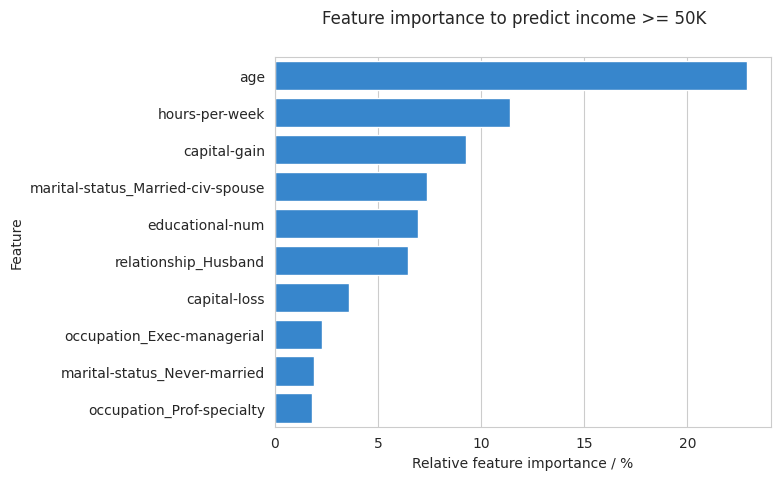

In [48]:
clf = pipeline_random_forest_classifier(
    X,
    y,
    n_estimators=10,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
)

n = 10
topn_feat_names, topn_feat_importances = get_topn_features(clf, feature_names, n)

plot_topn_features(topn_feat_names, topn_feat_importances, n)

#### Questions:

1. What features are in the top-10 most correlated with income >= 50K?
1. Is your dataset balanced?